In [15]:
import os, shutil, pathlib
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling

### Resize and rename images

```python
import os
from PIL import Image


def resize_and_rename_images(input_folder, output_folder, name, new_width=224, new_height=224):
    prefix = name
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    files = [f for f in os.listdir(input_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    for index, file in enumerate(files, start=1):
        img_path = os.path.join(input_folder, file)
        try:
            with Image.open(img_path) as img:
                img = img.resize((new_width, new_height), Image.LANCZOS)

                new_filename = f"{prefix}.{index:02d}.jpg"
                new_path = os.path.join(output_folder, new_filename)
                img.save(new_path, "JPEG")
                print(f"Processed and saved: {new_path}")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")


names = ["haarukka", "lusikka", "veitsi"]
for name in names:
    resize_and_rename_images(f"aterimet/{name}", f"aterimet_small", name)
```


### Setup Directories for Subsets
- Defining the base directory for output and the directory containing the original images.

In [16]:
new_base_dir = "kuvat"  # assuming base directory for output
original_dir = "aterimet_small"  # assuming base directory for original images

### Function to Create Subsets
-  A function to create subsets of the data for training, validation, and testing.
-  Create subsets: training (1-41), validation (42-50), and test (51-59) data

```python

# Function to create subsets
def make_subset(subset_name, start_index, end_index):
    for category in ("haarukka", "lusikka", "veitsi"):
        dir = os.path.join(new_base_dir, subset_name, category)
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i:02d}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=os.path.join(original_dir, fname), dst=os.path.join(dir, fname))
            
make_subset("train", start_index=1, end_index=43)
make_subset("validation", start_index=43, end_index=52)
make_subset("test", start_index=52, end_index=61)
```



### Load Datasets
- Use TensorFlow's `image_dataset_from_directory` to load the datasets for training, validation, and testing.

In [17]:
# Load datasets
train_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, "train"),
    image_size=(224, 224),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, "validation"),
    image_size=(224, 224),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    os.path.join(new_base_dir, "test"),
    image_size=(224, 224),
    batch_size=32
)

Found 126 files belonging to 3 classes.
Found 27 files belonging to 3 classes.
Found 27 files belonging to 3 classes.


### Data Augmentation
Apply augmentation only to the training dataset.
- Random Horizontal Flip: Randomly flips the image left to right.

- Random Rotation: Rotates the image by up to 36 degrees (both clockwise and counterclockwise).

- Random Zoom: Zooms in on the image by up to 20%.

These transformations help the model become more flexible and better at recognizing objects in different orientations, sizes, and positions.

In [18]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

# Apply augmentation only to the training dataset.
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

This script visualizes 9 different augmented versions of the same input image from the training dataset, using a 3x3 grid. The augmentations come from the data_augmentation function, and plt.imshow() renders each image.

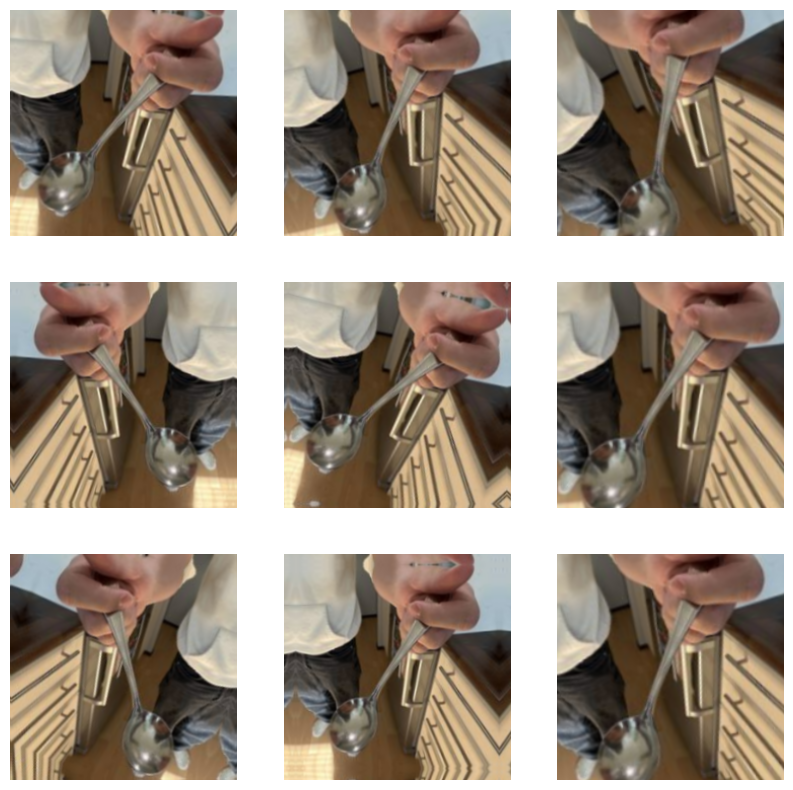

In [19]:
import matplotlib.pyplot as plt

# Create a figure with size 10x10 inches for displaying images
plt.figure(figsize=(10, 10))

dataset = train_dataset.repeat()
# Take one batch from the training dataset
for images, _ in dataset.take(1):
    # Loop 9 times to create 9 augmented versions
    for i in range(9):
        # Apply data augmentation to the batch
        augmented_image = data_augmentation(images, training=True)

        # Create a subplot in a 3x3 grid
        ax = plt.subplot(3, 3, i + 1)

        # Show the first image in the augmented batch
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")  # Hide axes for cleaner look

# Display the complete figure with all subplots
plt.show()


### Normalization
- Normalize the images by rescaling pixel values to the range [0, 1]. This is done by dividing the pixel values by 255. 
- scale = 1/255 → Divides all pixel values by 255

In [20]:
# Normalize pixel values to the range [0,1] by dividing by 255
normalization_layer = Rescaling(1./255)

# Apply normalization to the datasets
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

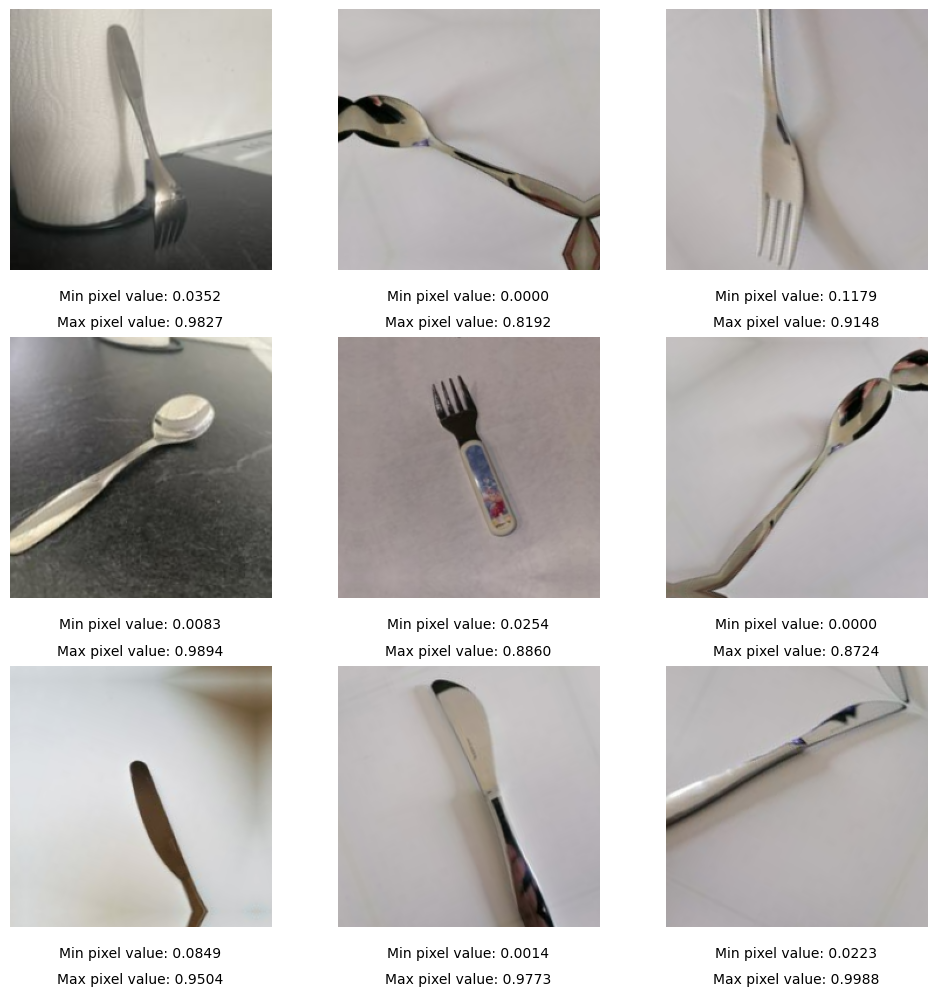

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
dataset = train_dataset.repeat()
# Iterate over the dataset (1 batch, take 9 images)
for i, (images, labels) in enumerate(dataset.take(1)):  # Only one batch
    for j in range(9):
        img = images[j].numpy()  # Access each image in the batch
        
        min_value = img.min()
        max_value = img.max()
               
        ax = plt.subplot(3, 3, j + 1)  # Create subplots in a 3x3 grid
        plt.imshow(img)
        plt.axis("off")
        
        # Display min pixel value below each image
        plt.text(0.5, -0.1, f"Min pixel value: {min_value:.4f}", 
                 ha='center', va='center', transform=ax.transAxes, fontsize=10, color='black')
        
        # Display max pixel value below min, adjusting y-position
        plt.text(0.5, -0.2, f"Max pixel value: {max_value:.4f}", 
                 ha='center', va='center', transform=ax.transAxes, fontsize=10, color='black')
        plt.text(0.5, 0.2, f" ", 
                 ha='center', va='center', transform=ax.transAxes, fontsize=10, color='black')

plt.tight_layout()
plt.show()
